<h1>Challenge Analysis: Plots & Regression Analysis </h1>

In [22]:
# general project set-up and libraries: 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression


# reading in the data: 
chal  = pd.read_csv("./Data/Challenges_Nov24_Final.csv")

# okay this csv file is missing the prize num and duration values: 
chal_add = chal.copy()
prize_num = []
for i, r in chal_add.iterrows():
    if r["Prize Amount"] == "No monetary prize for this challenge":
        prize_num.append(0)
    else:
        prize_num.append(float(r["Prize Amount"].replace("$","").replace(",","").split(".")[0]))
chal_add["prize_num"] = prize_num
chal_add["duration"] = pd.to_datetime(chal_add['Challenge End Date']) - pd.to_datetime(chal_add['Challenge Start Date'])
chal_add["duration_days"] = chal_add["duration"].values.astype('timedelta64[D]') / np.timedelta64(1, 'D')

chal_add.head()

# let's go ahead and remove that 2009 entry: 
chal_add = chal_add[chal_add.start_year != 2009]

# exporting this: 
import csv
chal_add.to_csv("./Data/Challenges_Nov24_FinalTidy.csv", sep = '\t', encoding = 'utf-8')

<h2> Plotting Challenges for Environmental vs. Non-Environmental Agencies </h2>

/Users/emmalitsai/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


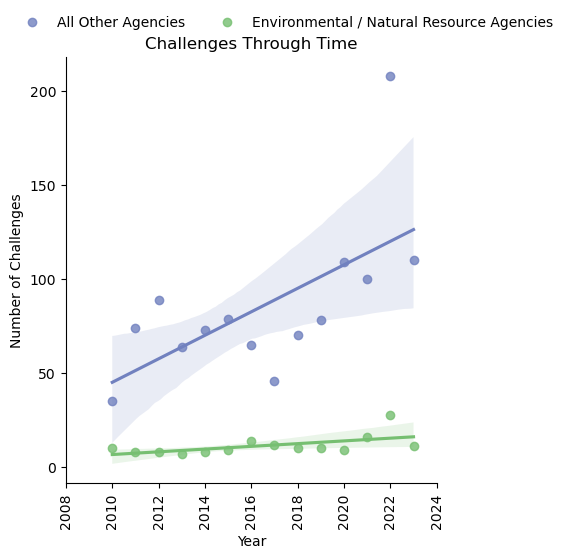

In [7]:
# Plotting challenges for environmental vs non-environmental agencies: 
challenge_totals = chal_add.groupby(["env_flag","start_year"]).count().reset_index()

plot_total = sns.lmplot(x = "start_year", y = "count",
           hue = "env_flag", data = challenge_totals, palette=["#7181bf", "#76bf71"])
sns.move_legend(
    plot_total, "lower center",
    bbox_to_anchor=(.4, 1), ncol=3, title=None, frameon=False,
)
plot_total.set(title="Challenges Through Time").set_xticklabels(rotation=90).set_xlabels("Year").set_ylabels("Number of Challenges")
plot_total.savefig("./Results/enviro_nonenviro_trends.png")

<h2>Linear Regression</h2>

In [31]:
# what's the linear regression for this? 
# grabbing environmental and non-enviro agencies: 
non_env = chal_add[(chal_add.env_flag == "All Other Agencies")]
env = chal_add[(chal_add.env_flag == "Environmental / Natural Resource Agencies")]

# grouping by year for non-enviro agencies: 
non_env_summary = non_env.groupby('start_year', as_index = False).count()
env_summary = env.groupby('start_year', as_index = False).count()

# grabbing desired x and y values: 
x_non_env = non_env_summary["start_year"]
y_non_env = non_env_summary["count"]

model = LinearRegression().fit(x_non_env.values.reshape(-1,1), y_non_env)
model.score(x_non_env.values.reshape(-1,1), y_non_env) # r_sq is only 0.4034
model.coef_ # 6.24 Challenges/year

0.40342903723031776

In [34]:
# linear regression results for environmental agencies
# grouping by year for enviro agencies: 
x_env = env_summary["start_year"]
y_env = env_summary["count"]

model_env = LinearRegression().fit(x_env.values.reshape(-1,1), y_env)
model_env.score(x_env.values.reshape(-1,1), y_env) # r_sq is only 0.3187 -- generally these are both weak positive relationships. 
model_env.coef_ # 0.72 Challenges/year

array([0.72527473])

<h2>Faceted graph by primary challenge type: </h2>


/Users/emmalitsai/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


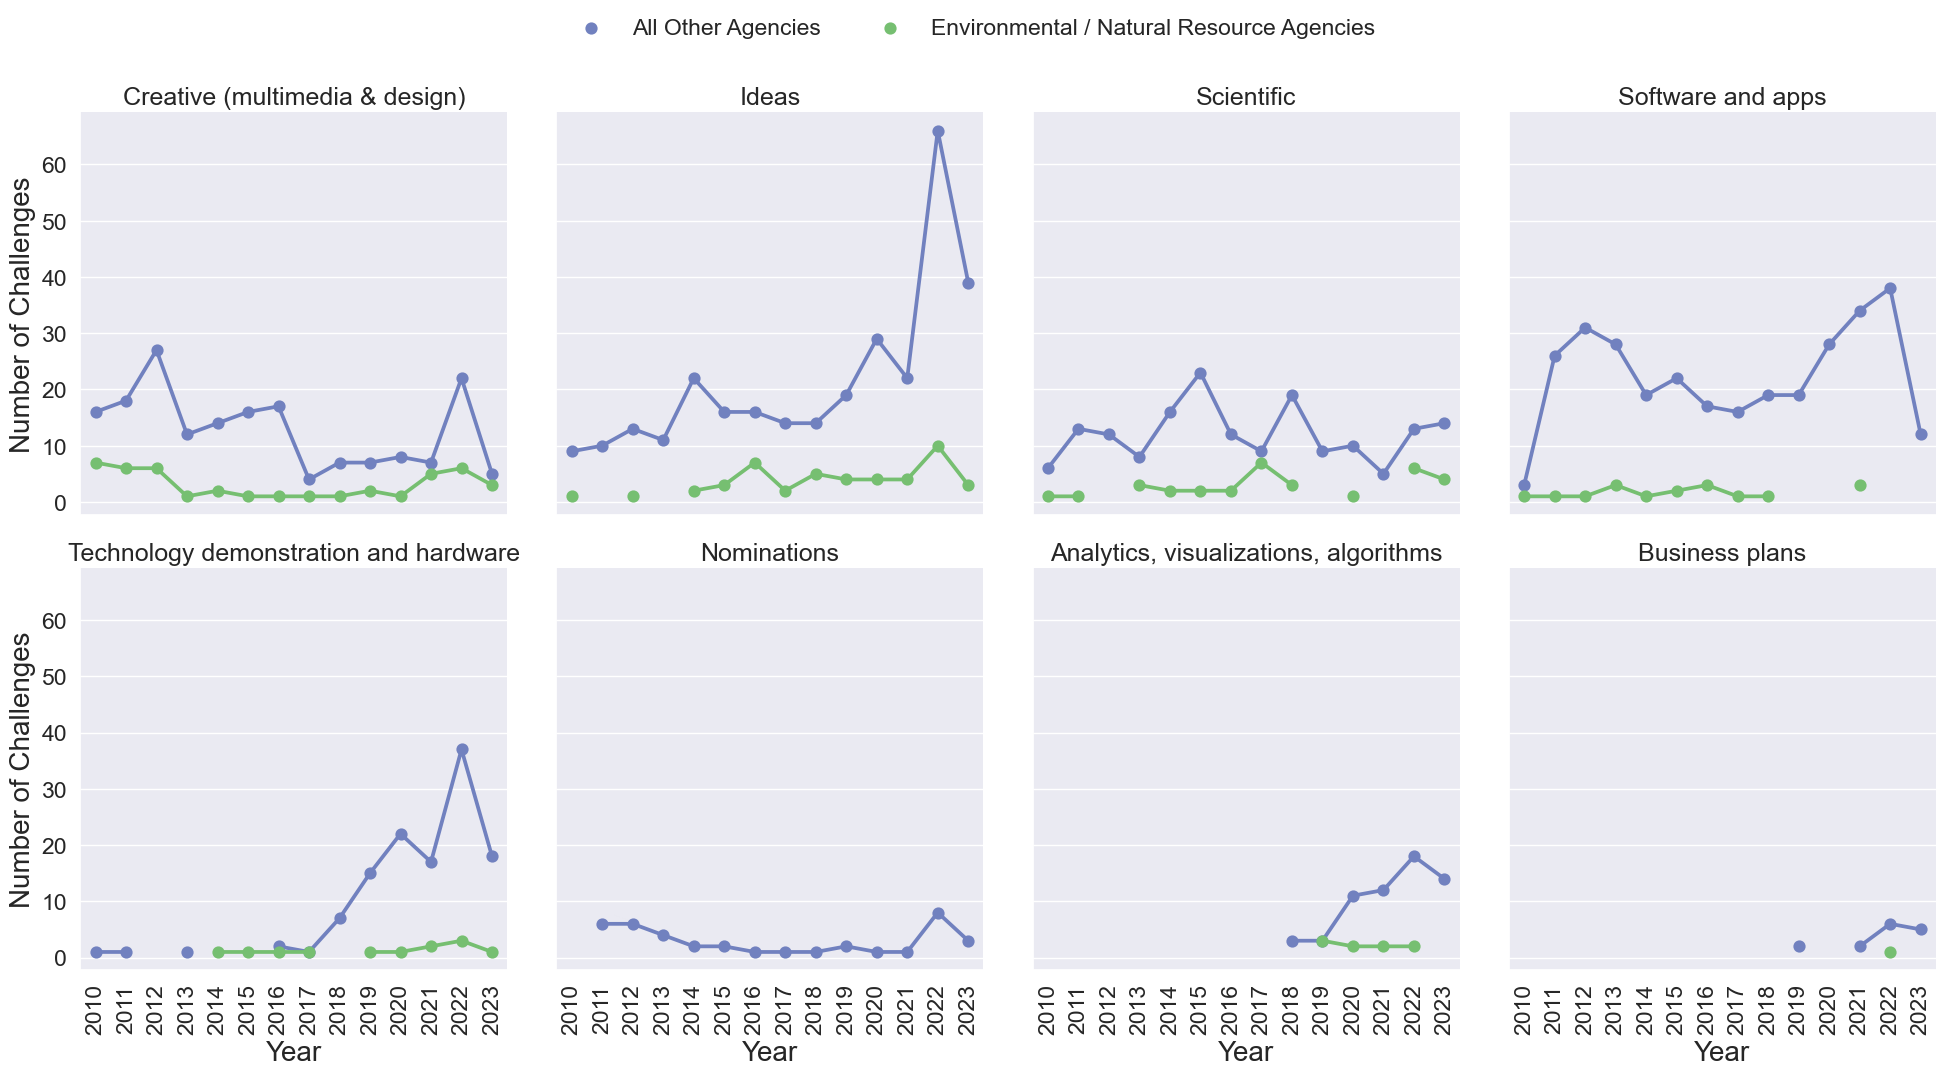

In [50]:
# grouping data for challenge types
challenge_type = chal_add.groupby(["env_flag","start_year", "Primary Challenge Type"]).count().reset_index()

# setting font scale: 
sns.set(font_scale = 1.5)

challenge_type_plot = sns.catplot(kind="point",data=challenge_type, x="start_year",y="count", hue='env_flag', palette=["#7181bf", "#76bf71"], 
            col_wrap=4, col='Primary Challenge Type')
challenge_type_plot.set_titles(col_template="{col_name}", row_template="{row_name}")
sns.move_legend(
    challenge_type_plot, "lower center",
    bbox_to_anchor=(.4, 1), ncol=3, title=None, frameon=False,
)
challenge_type_plot.tick_params(axis='x', rotation=90).set_xlabels("Year", fontsize = 20).set_ylabels("Number of Challenges", fontsize = 20)
challenge_type_plot.savefig("./Results/primary_type_trends.png")

<h2> Linear Regressions by Challenge Type </h2>

In [53]:
# grabbing specific challenge types  -- there's definitely a better way to do all of this but I'm strapped for time at the moment! 
software = challenge_type[challenge_type['Primary Challenge Type'] == 'Ideas']

# Filter the data further
other = software[software['env_flag'] == 'All Other Agencies']
env = software[software['env_flag'] != 'All Other Agencies']

# grabbing desired x and y values: 
other_x = other["start_year"]
other_y = other["count"]
env_x = env["start_year"]
env_y = env["count"]
 
# Linear regression 
model = LinearRegression().fit(other_x.values.reshape(-1,1), other_y)
model.coef_ 
model_env = LinearRegression().fit(env_x.values.reshape(-1,1), env_y)
model_env.coef_ 

# organizing results
print("non env")
print(model.intercept_)
print(model.coef_)
print("env")
print(model_env.intercept_)
print(model_env.coef_)

# These also align with my calcs in R: 

# software other = 0.58 slope; -1156.59 intercept
# software env = 0.12 slope; -232.48 intercept 

# ideas other = 2.62 slope; -5252.49 intercept
# ideas env = 0.37 slope; -748.75 intercept

# creative other = -0.84 slope; 1705.83 intercept
# creative env = -0.13 slope; 273.41 intercept

# tech other = 2.14 slope; -4310.68 intercept
# tech env = 0.11 slope; - 227.80 intercept

# analytics other = 2.89 slope; -5820.42 intercept
# analytics env = -0.3 slope; 608.40 intercept 

# scientific other = 0.01 slope; -10.09 intercept
# scientific env = 0.26 slope; -514.89 intercept

# Business other = 0.94 slope; -1902.00 intercept 
# Business env = 1.0 slope; 0. intercept (only one data point here)

# Nominations other = -0.13 slope; 257.82 intercept

non env
-5252.494505494504
[2.61538462]
env
-748.7452080411406
[0.37307153]


<h2> Challenge Use By Department</h2>

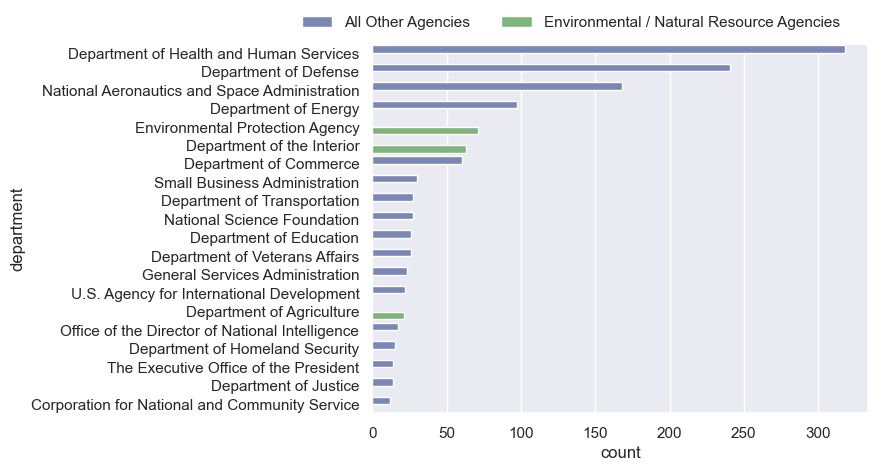

In [71]:
chal_dept = chal_add.groupby(['env_flag', "department"]).count().reset_index()
plot_order = chal_dept.sort_values(by='count', ascending=False)

# setting font scale: 
sns.set(font_scale = 1)

# oof the spacing doesn't look great but can fiddle with this as needed 
chal_dept_plt = sns.barplot(data=plot_order.iloc[:20],x="count",y="department", hue='env_flag', palette=["#7181bf", "#76bf71"])
sns.move_legend(
    chal_dept_plt, "lower center",
    bbox_to_anchor=(.4, 1), ncol=3, title=None, frameon=False,
)

# I ended up making this plot in R since I like the rounded corners that the ggchicklet package provides, but replicated it here for QA/QC purposes
# the two are relatively identical aside from some stylistic choices 

<h2> Breakdown by Year </h2>

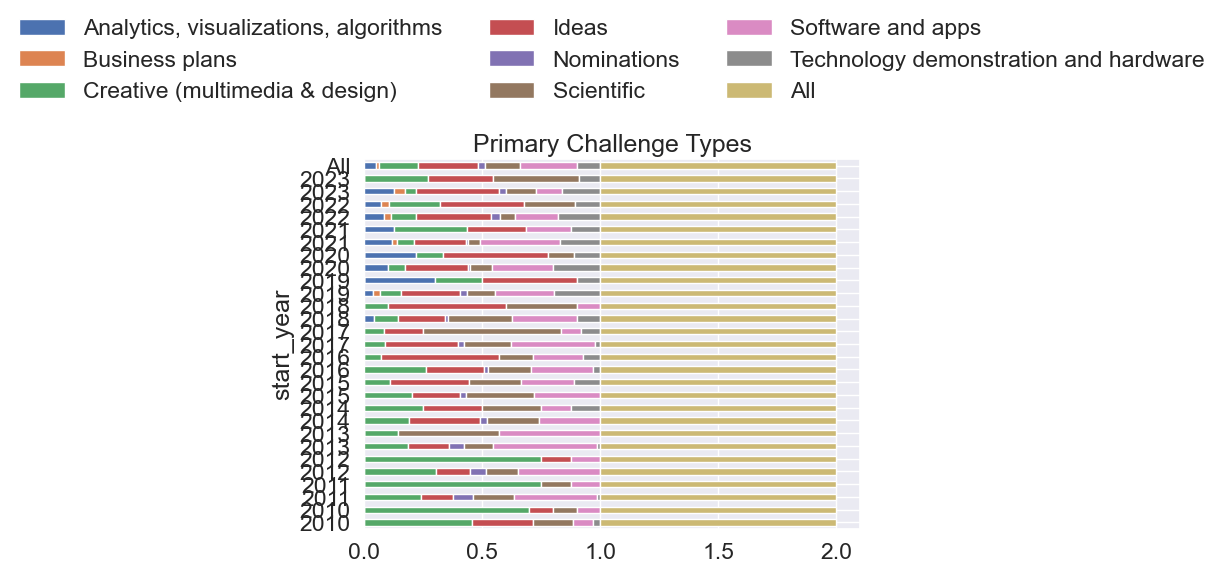

In [55]:
# grouping data by enviro flag, start year, and primary challenge type 
chal_bkdwn = chal_add.groupby(['env_flag', "start_year", "Primary Challenge Type"]).count().reset_index()

# grabbing a mini df to work with:
chal_bkdwn_mini = chal_bkdwn[["start_year", "Primary Challenge Type", "env_flag", "count"]]

# pivoting wider for easier plotting: 
chal_bkdwn_mini_wider = chal_bkdwn_mini.pivot_table(index=['start_year', 'env_flag'], 
                    columns='Primary Challenge Type', 
                    values='count', 
                    aggfunc= sum, 
                    fill_value = 0,
                    margins=True).reset_index()

# calculating percentages 
chal_bkdwn_per_div = chal_bkdwn_mini_wider.iloc[:,2:11].div(chal_bkdwn_mini_wider.All, axis=0).reset_index()

# grabbing the start years  and flag again: 
chal_years_flag = chal_bkdwn_mini_wider[["start_year", "env_flag"]]

# tidying 
result = pd.concat([chal_bkdwn_per_div, chal_years_flag], axis = 1)
result = result.drop(['index'], axis=1)
# result = result.drop(['All'], axis=1)

# plotting - need to facet this 
result_plot = result.plot( 
    x = 'start_year', 
    kind = 'barh', 
    stacked = True, 
    title = 'Primary Challenge Types', 
    mark_right = True)
sns.move_legend(
    result_plot, "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=3, title=None, frameon=False,
)

# unsure how to fix this figure but the stats should be available in the result data frame

<h2>Looking at Prize Amount</h2>

/Users/emmalitsai/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


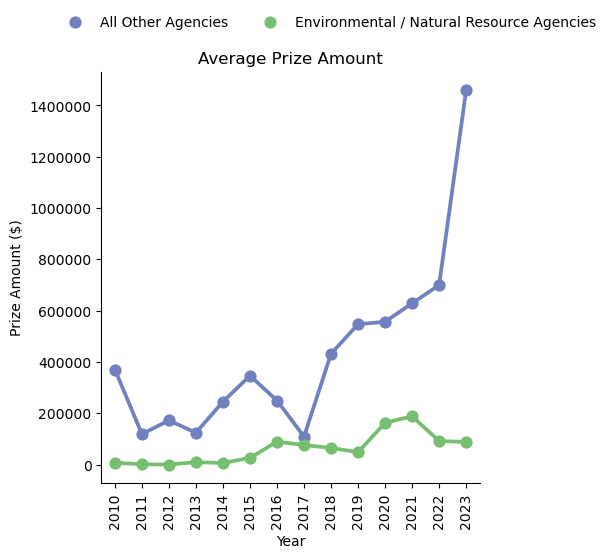

In [17]:
challenge_totals_4 = chal_add.groupby(['env_flag',"start_year"]).agg({"prize_num":'mean'}).reset_index()
prize_amt = sns.catplot(kind = "point", data = challenge_totals_4,x="start_year",y="prize_num", hue = 'env_flag', palette=["#7181bf", "#76bf71"])
prize_amt.set(title="Average Prize Amount").set_xticklabels(rotation=90).set_xlabels("Year").set_ylabels("Prize Amount ($)")
sns.move_legend(
    prize_amt, "lower center",
    bbox_to_anchor=(.4, 1), ncol=3, title=None, frameon=False,
)
plt.ticklabel_format(style='plain', axis='y')
prize_amt.savefig("./Results/prize_amt.png")

In [67]:
# how many don't offer any prize amounts? 
no_money = chal_add[chal_add['prize_num'] == 0]
no_money.groupby(['env_flag']).count()
# 61 env agencies don't offer $$, compared to 285 of all other agencies 
chal_add.groupby("env_flag").count()
# there's 160 environmental challenges and 1200 other agencies; 
# subtracting % environmental agency w/o $$ from % other agency w/o $$: 
((61/160)*100) - ((285/1200)*100) # difference of 14.4%

14.375

<h2>Looking at Duration</h2>

/Users/emmalitsai/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


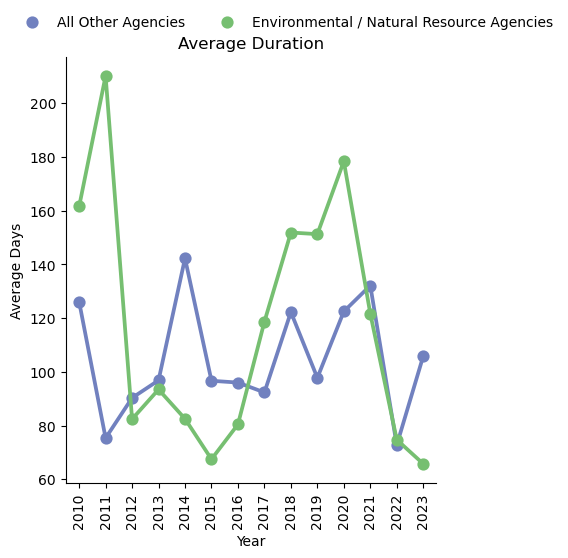

In [18]:
challenge_totals_5 = chal_add.groupby(['env_flag',"start_year"]).agg({"duration_days":'mean'}).reset_index()
prize_dur = sns.catplot(kind = "point", data = challenge_totals_5,x="start_year",y="duration_days", hue = 'env_flag', palette=["#7181bf", "#76bf71"])
prize_dur.set(title="Average Duration").set_xticklabels(rotation=90).set_xlabels("Year").set_ylabels("Average Days")
sns.move_legend(
    prize_dur, "lower center",
    bbox_to_anchor=(.4, 1), ncol=3, title=None, frameon=False,
)
plt.ticklabel_format(style='plain', axis='y')
prize_dur.savefig("./Results/prize_dur.png")